In [8]:
import numpy as np
from random import choice, random
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.animation as animation
import matplotlib.patches as mpatches
from typing import Tuple
from tqdm import tqdm

In [9]:
class AdaptativeAgent():
    def __init__(
        self,
        initial_state: Tuple[int, int],
        actions: list,
        n_rows: int,
        n_cols: int,
        alpha: float = 0.1,    # Tasa de aprendizaje
        gamma: float = 0.9,    # Factor de descuento
        min_epsilon: float = 0.1,
        decay_rate: float = 0.003
    ):
        # Parámetros de Q-learning
        self.alpha = alpha
        self.gamma = gamma
        self.min_epsilon = min_epsilon
        self.decay_rate = decay_rate
        
        # Configuración del entorno
        self.n_rows = n_rows
        self.n_cols = n_cols
        self.actions = actions
        
        # Estado inicial
        self.initial_state = initial_state
        self.current_state = initial_state
        
        # Q-table (diccionario de diccionarios)
        self.q_knowledge = {}
        # Memoria corta
        self.short_term_memory = {}
        
        # Contadores
        self.steps = 0
        
        self._init_q_table_and_stm()
        
        
    
    def _init_q_table_and_stm(self):
        """Inicializa la Q-table con ceros para todas las combinaciones estado-acción"""
        for row in range(self.n_rows):
            for col in range(self.n_cols):
                state = (row, col)
                self.q_knowledge[state] = {action: 0.0 for action in self.actions}
                # Inicializa memoria corta
                self.short_term_memory[state] = [0]*10
                
    
    def get_next_state(self, base_state: Tuple[int, int], action: str) -> Tuple[int, int]:
        """Calcula el próximo estado según la acción"""
        row, col = base_state
        
        if action == 'Up':
            return (max(row-1, 0), col)
        if action == 'Down':
            return (min(row+1, self.n_rows-1), col)
        if action == 'Left':
            return (row, max(col-1, 0))
        if action == 'Right':
            return (row, min(col+1, self.n_cols-1))
        return base_state  # Caso por defecto
    
    def get_best_action(self, state: Tuple[int, int]) -> Tuple[str, float]:
        """Selecciona la mejor acción usando explotación"""
        q_values = self.q_knowledge[state]
        max_q = max(q_values.values())
        
        # Filtra acciones con valor máximo
        best_actions = [a for a, q in q_values.items() if q == max_q]
        return choice(best_actions), max_q
    
    def update_q_value(
        self,
        current_state: Tuple[int, int],
        action: str,
        reward: float,
        next_state: Tuple[int, int]
    ) -> None:
        """Actualiza la Q-table según la ecuación de Q-learning"""
        current_q = self.q_knowledge[current_state][action]
        _, next_max_q = self.get_best_action(next_state)
        
        # Ecuación de Q-learning tradicional
        new_q = current_q + self.alpha * (reward + self.gamma * next_max_q - current_q)
        self.q_knowledge[current_state][action] = new_q
        
        return new_q
    
    def choose_action(self, epsilon: float) -> str:
        """Selección de acción epsilon-greedy"""
        if random() < epsilon:
            # Exploración: acciones válidas (que cambian el estado)
            valid_actions = [
                a for a in self.actions
                if self.get_next_state(self.current_state, a) != self.current_state
            ]
            return choice(valid_actions)
        
        # Explotación
        best_action, _ = self.get_best_action(self.current_state)
        return best_action
    
    def epsilon_decay(self, step) -> float:
        """Decaimiento exponencial de epsilon"""
        return self.min_epsilon + (1 - self.min_epsilon) * np.exp(-self.decay_rate*step)
    
    def move(self, reward: float, action: str) -> None:
        """
        Realiza un paso completo de Q-learning:
        1. Actualiza Q-table con la observación actual
        2. Cambia al nuevo estado
        """
        # Actualización Q-learning
        
        next_state = self.get_next_state(self.current_state, action)
        
        new_q = self.update_q_value(
                    current_state=self.current_state,
                    action=action,
                    reward=reward,
                    next_state=next_state
                )
        
        
        # STM
        self.short_term_memory[self.current_state] = self.short_term_memory[self.current_state][1:] + [new_q]
        
        base_memo = self.short_term_memory[self.current_state][:-1]
        sign = self.short_term_memory[self.current_state][-1] - np.mean(base_memo)
        criteria = abs(sign) > 3*np.std(base_memo)
        
        if criteria:
            criteria = 'pos' if sign > 0 else 'neg'
            
            
        # Actualizar estado y contadores
        self.current_state = next_state
        self.steps += 1
                
        return new_q, criteria
    
    def restart(self) -> None:
        """Reinicia el agente a su estado inicial"""
        self.current_state = self.initial_state
        self.steps = 0

    def __str__(self) -> str:
        return f"AdaptativeAgent at {self.current_state} with Q-values {self.q_knowledge[self.current_state]}"

### With Memory

In [10]:
N_ROWS = 9
N_COLS = 9
GRID_WORLD = np.zeros((N_ROWS, N_COLS))-1

GOAL_STATE_1 = (0, 0)
GOAL_STATE_2 = (8, 8)
GRID_WORLD[GOAL_STATE_1] = 100 

EXPLOTATION = 0.15

# Inicialización
agent = AdaptativeAgent(
    initial_state=(4,4),
    actions=['Up', 'Down', 'Left', 'Right'],
    n_rows=N_ROWS,
    n_cols=N_COLS,
    decay_rate=0.002,
    alpha=0.9
)


learning_curve = []
exploration_curve = []
step_changes = []
episode_changes = [100, 300, 550, 750, 950]

q_learning = 0
episode = 0
ite = 0
c = 0
flag = 0

criteria = None
anomaly_episode = None

# Episodio de entrenamiento
while episode != 1100:
    # 1. Elegir acción
    epsilon = agent.epsilon_decay(step=c)
    action = agent.choose_action(epsilon)
    initial_state = agent.current_state
    
    next_state = agent.get_next_state(initial_state, action)
    reward = GRID_WORLD[next_state]
    
    new_q, criteria = agent.move(reward, action)
    q_learning += new_q
    
    exploration_curve.append([epsilon, new_q])
    
    ite += 1
    c += 1
    
    if (criteria=='neg') and (epsilon < EXPLOTATION) and (anomaly_episode!=episode):
        pass
        #c=0
        #anomaly_episode = episode
        #print(f"Anomaly detected at episode {episode} with criteria {criteria}")
        #c = 0
    #for a in agent.actions:
    #    prev_state = agent.get_next_state(initial_state, a)
    #    if (prev_state in [GOAL_STATE_1, GOAL_STATE_2, initial_state]):
    #        continue 
    #    original_q = agent.q_knowledge[prev_state][a]
    #    agent.q_knowledge[prev_state][a] = (original_q + 4*new_q)/5
            

    
    if (next_state in [GOAL_STATE_1, GOAL_STATE_2]) or (agent.steps > (N_COLS+N_ROWS)*2):
        episode += 1
        agent.restart()
        learning_curve.append(q_learning/ite)
        
        if episode in episode_changes:
            c=0
            
            for a in agent.actions:
                prev_state = agent.get_next_state(initial_state, a)
                if (prev_state in [GOAL_STATE_1, GOAL_STATE_2, initial_state]):
                    continue 
                for a_prev in agent.actions:
                    original_q = agent.q_knowledge[prev_state][a_prev]
                    agent.q_knowledge[prev_state][a_prev] = (original_q + new_q)/2
                    
            if episode%150!=0:
                GRID_WORLD[GOAL_STATE_1] = -1
                GRID_WORLD[GOAL_STATE_2] = 100
            else:
                GRID_WORLD[GOAL_STATE_1] = 100
                GRID_WORLD[GOAL_STATE_2] = -1
                
            step_changes.append(ite)

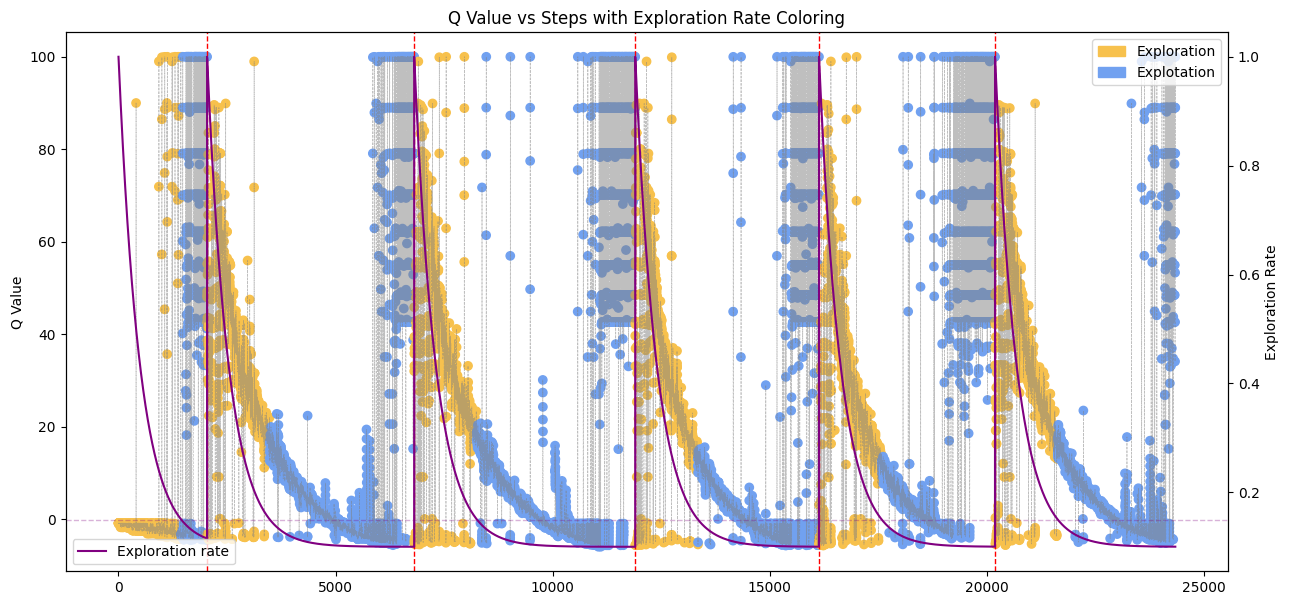

In [11]:
eps, q_val = list(zip(*exploration_curve))

plt.figure(figsize=(15, 7))
plt.plot(q_val, c='gray', alpha=0.5, linestyle='--', linewidth=.5)
plt.scatter(range(len(q_val)), q_val, c=['#71a1f0'if e < EXPLOTATION else '#f7c14d'for e in eps])
plt.ylabel('Q Value')

blue_patch = mpatches.Patch(color='#71a1f0', label='Explotation',)
orange_patch = mpatches.Patch(color='#f7c14d', label='Exploration')
plt.legend(handles=[orange_patch, blue_patch], loc='upper right', fontsize=10)

for change in step_changes:
    plt.axvline(x=change, color='red', linestyle='--', linewidth=1)

# add another axis
plt.twinx()
plt.plot(eps, label=f'Exploration rate', c='purple')
plt.axhline(EXPLOTATION, color='purple', linestyle='--', alpha=0.3, linewidth=1)
plt.ylabel('Exploration Rate')
plt.legend(loc='lower left')
plt.xlabel('Steps')

plt.title('Q Value vs Steps with Exploration Rate Coloring')

plt.show()

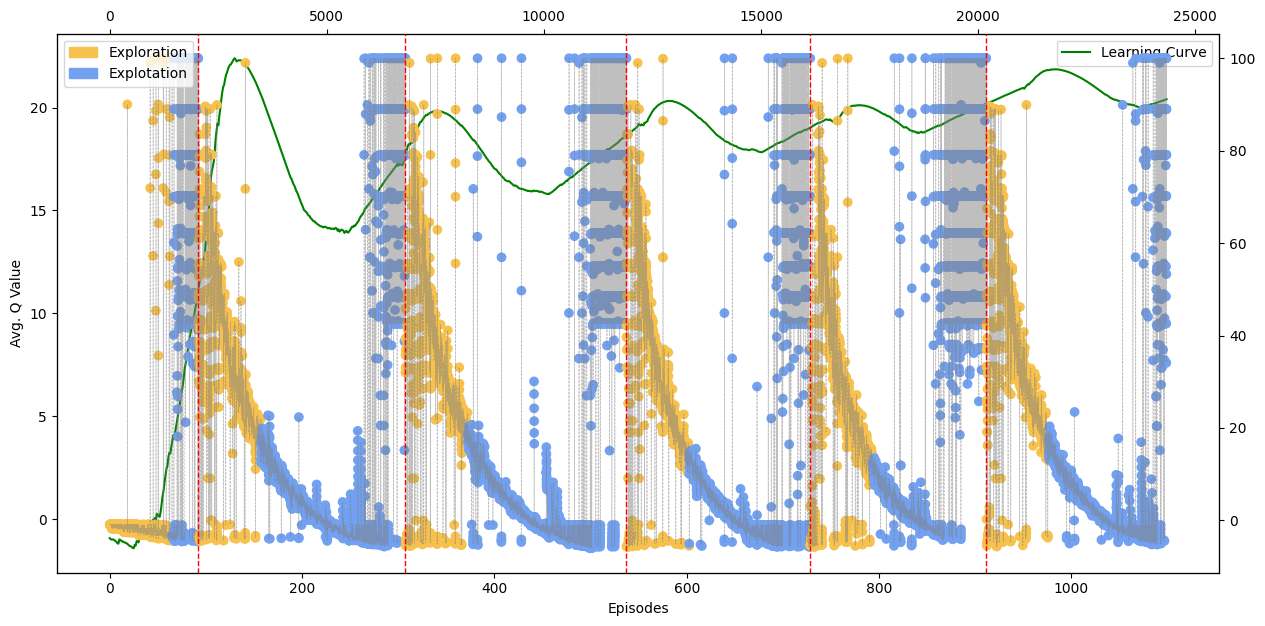

In [12]:
plt.figure(figsize=(15, 7))

plt.plot(learning_curve, c='green', zorder=1000, label='Learning Curve')
plt.ylabel('Avg. Q Value')
plt.xlabel('Episodes')
plt.legend()

    
plt.twinx()
plt.twiny()
plt.plot(q_val, c='gray', alpha=0.5, linestyle='--', linewidth=.5)
plt.scatter(range(len(q_val)), q_val, c=['#71a1f0'if e < EXPLOTATION else '#f7c14d'for e in eps])
plt.ylabel('Q Value')
for change in step_changes:
    plt.axvline(x=change, color='red', linestyle='--', linewidth=1)

blue_patch = mpatches.Patch(color='#71a1f0', label='Explotation',)
orange_patch = mpatches.Patch(color='#f7c14d', label='Exploration')
plt.legend(handles=[orange_patch, blue_patch], loc='upper left', fontsize=10)


plt.show()

In [13]:
POLICY_MAP = np.zeros((N_ROWS, N_COLS))
LABEL_MAP = np.empty((N_ROWS, N_COLS), dtype=object)

for row in range(N_ROWS):
    for col in range(N_COLS):
        action, value = agent.get_best_action((row, col))
        POLICY_MAP[row, col] = value
        LABEL_MAP[row, col] = f'{action}\n{value:.2f}'

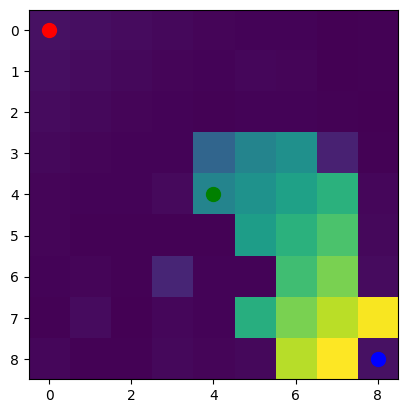

In [14]:
plt.imshow(POLICY_MAP, cmap='viridis', interpolation='nearest')
plt.scatter(*GOAL_STATE_1[::-1], c='red', s=100, label='Goal 1')
plt.scatter(*GOAL_STATE_2[::-1], c='blue', s=100, label='Goal 2')
plt.scatter(*agent.initial_state[::-1], c='green', s=100, label='Start')